# Getting started with yieldplotlib

## Introduction
This tutorial will walk you thorugh some of the basic functionality of yieldplotlib to get you started on generating your own yield visualizations. To run yieldplotlib you need to have at least one AYO output folder, EXOSIMS output folder, or yield input package (YIP). Sample data has been provided in the tutorials folder of this repository for demonstrative purposes. 

You can also run series of pre-made plots for yield outputs which can be found in the yieldplotlib/src/scripts folder, or accessed through the yieldplotlib pipeline and command line interface.

### Imports

In [3]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
from IPython.display import HTML

import yieldplotlib as ypl
from yieldplotlib.accessibility import AccessibilityManager
from yieldplotlib.load.ayo_directory import AYODirectory
from yieldplotlib.load.exosims_directory import EXOSIMSDirectory
from yieldplotlib.load.yip_directory import YIPDirectory
from yieldplotlib.logger import logger
from yieldplotlib.plots.yip_plots import make_offax_psf_movie, plot_core_throughtput

### Loading Yield Data

 Yieldplotlib uses a key map to equate parameters between EXOSIMS and AYO (and
  potential future yield codes). This key map is pulled daily from a collaborative Google Sheet to the GitHub repository in the form of a key_map.csv file. To see all the possible named parameters that can be plotted in yieldplotlib, consult documentation or the first column of that CSV file/Google Sheet. 

In order to convert this CSV to the key_map.py file that is needed by yieldplotlib to parse the yield output directories, the user should run:

`python generate_key_map.py --csv key_map.csv`

This will populate a key_map.py file containing all the proper mappings. Now we can load our sample AYO and EXOSIMS data using the AYODirectory and EXOSIMSDirectory classes.  

In [4]:
%%capture
logger.setLevel(logging.ERROR)
ayo_folder = Path("sample_data/ayo")
exosims_folder = Path("sample_data/exosims")

ayo = AYODirectory(ayo_folder)
exosims = EXOSIMSDirectory(exosims_folder)

Now that we have loaded our directories, we can display the file structure to see what is contained in our yield outputs at a glance.

In [35]:
logger.setLevel(logging.WARNING)
print(exosims.display_tree())
print(ayo.display_tree())

<EXOSIMSDirectory: exosims>
├── <DRMDirectory: drm>
│   ├── <DRMFile: 91821668.pkl>
│   ├── <DRMFile: 611229025.pkl>
│   ├── <DRMFile: 150988834.pkl>
│   ├── <DRMFile: 530322504.pkl>
│   ├── <DRMFile: 534826309.pkl>
│   └── ... and 95 more
├── <SPCDirectory: spc>
│   ├── <SPCFile: 746681848.spc>
│   ├── <SPCFile: 992454934.spc>
│   ├── <SPCFile: 46942734.spc>
│   ├── <SPCFile: 773541182.spc>
│   ├── <SPCFile: 631110355.spc>
│   └── ... and 95 more
├── <EXOSIMSInputFile: Example_EXOSIMS.json>
├── <EXOSIMSCSVDirectory: csv>
│   ├── <EXOSIMSCSVFile: reduce-radlum.csv>
│   ├── <EXOSIMSCSVFile: reduce-earth-char-count.csv>
│   ├── <JSONFile: Example_EXOSIMS.json>
│   ├── <EXOSIMSCSVFile: reduce-yield-time.csv>
│   ├── <EXOSIMSCSVFile: reduce-earth.csv>
│   └── ... and 12 more
└── <EXOSIMSInputFile: local_Example_EXOSIMS.json>

<AYODirectory: ayo>
├── <AYOCSVFile: target_list.csv>
├── <AYOCSVFile: coronagraph1.csv>
├── <AYOInputFile: yield_run.ayo>
└── <AYOCSVFile: observations.csv>



## Accessing Data and Generating Plots 
We have our data loaded and can now start accessing it and generating 
plots!

### Get Data
Data can be accessed from the AYODirectory and EXOSIMSDirectory using the .get() function which takes the named yieldplotlib keys as input and outputs the corresponding values. This can be in the form of singular values or arrays.

In [6]:
# Pupil diameter
ayo_pup = ayo.get("pupil_diam")
exo_pup = exosims.get("pupil_diam")
print(f"Pupil diameters are:\nAYO: {ayo_pup} \nEXOSIMS: {exo_pup}")

# ExoEarth yields
ayo_yield = ayo.get("yield_earth")
exo_yield = exosims.get("yield_earth")
print(f"\nExoEarth yields are:\nAYO: {ayo_yield} \nEXOSIMS: {exo_yield}")

# Target star distances (first 10)
ayo_dist = ayo.get("star_dist")
exo_dist = exosims.get("star_dist")
print(f"\nStellar distances (pc) are:\nAYO: {ayo_dist[:10]} \nEXOSIMS: {exo_dist[:10]}")

Pupil diameters are:
AYO: 7.22577 m 
EXOSIMS: 7.225765

ExoEarth yields are:
AYO: 21.81181898211 
EXOSIMS: [17.15]

Stellar distances (pc) are:
AYO: [ 1.34749  3.49736  1.34749  5.12952  7.70357  7.4783  11.3417  11.091
 15.3728  13.9204 ] pc 
EXOSIMS: [26.39 15.89  4.34 11.31 25.71 13.67 27.44 18.75 21.28 20.19]


### Generic Plots

yieldplotlib expands directly on matplotlib to utilize its functionality and to make plot customization intuitive for those who have familiarity with matplotlib and its features. Below are examples of some of the generic yieldplotlib plots that one can make.

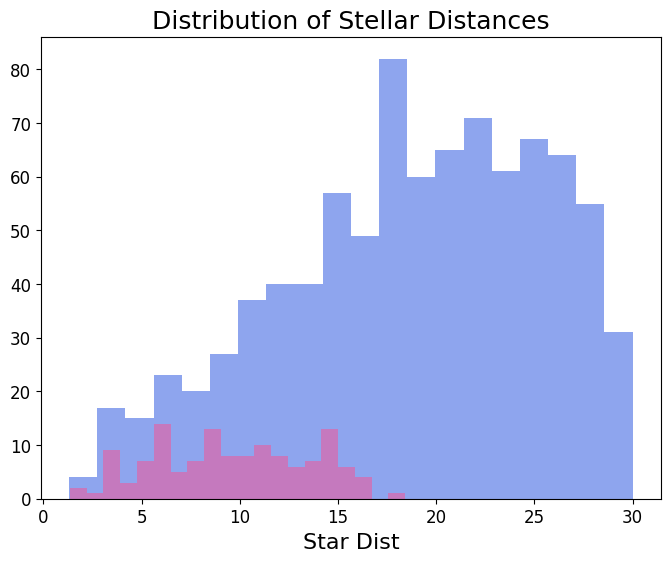

In [9]:
# Histograms

fig, ax = plt.subplots(figsize=(8, 6))
ax.ypl_hist(exosims, x="star_dist", bins=20, alpha=0.7, label="EXOSIMS Stars")
ax.ypl_hist(ayo, x="star_dist", bins=20, alpha=0.7, label="AYO Stars")
ax.set_title("Distribution of Stellar Distances")
plt.show()

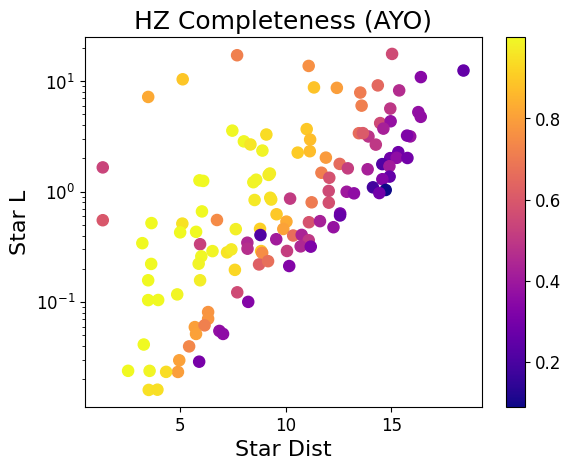

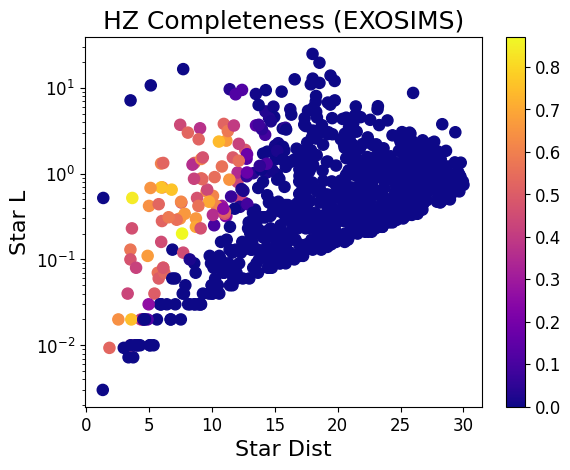

In [30]:
# Scatter Plots
fig, ax = plt.subplots()
data = ax.ypl_scatter(ayo, x="star_dist", y="star_L", c="star_comp_det")
ax.set_title("HZ Completeness (AYO)")
ax.set_yscale("log")
plt.colorbar(data)

fig, ax = plt.subplots()
data = ax.ypl_scatter(exosims, x="star_dist", y="star_L", c="star_comp_det")
ax.set_title("HZ Completeness (EXOSIMS)")
ax.set_yscale("log")
plt.colorbar(data)
plt.show()

### Comparative Plots 

Instead of plotting datasets individually, for comparison purposes it is often desired to plot different yield outputs in a single figure. Here the suite of available yieldplotlib comparative plots should be used. Lets see two examples plotting the same HZ completeness plot as above. 

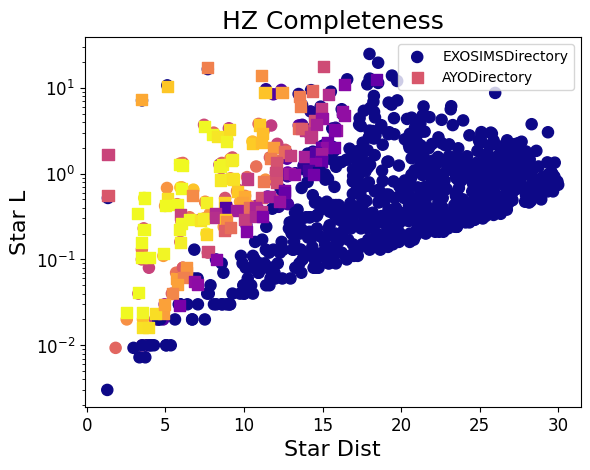

In [13]:
# Two yield runs on same set of axes.

fig, ax = plt.subplots()
ax.set_title("HZ Completeness")
data = ypl.compare(
    ax,
    [exosims, ayo],
    x="star_dist",
    y="star_L",
    plot_type="scatter",
    c="star_comp_det",
)
ax.set_yscale("log")
plt.show()

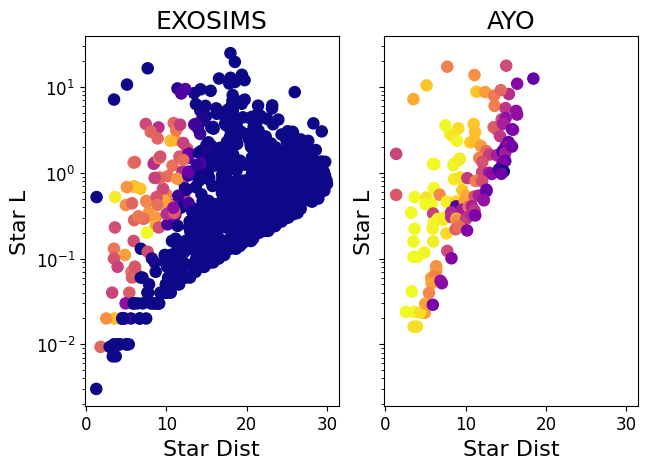

In [32]:
# Two yield runs on different sets of axes.

fig, axs = ypl.multi(
    [exosims, ayo],
    x="star_dist",
    y="star_L",
    plot_type="scatter",
    c="star_comp_det",
    sharex=True,
    sharey=True,
    titles=["EXOSIMS", "AYO"],
)
axs[0, 0].set_yscale("log")
plt.show()

Additionally, we can run more complex analyses on multi-dimensional grids of parameter space. 

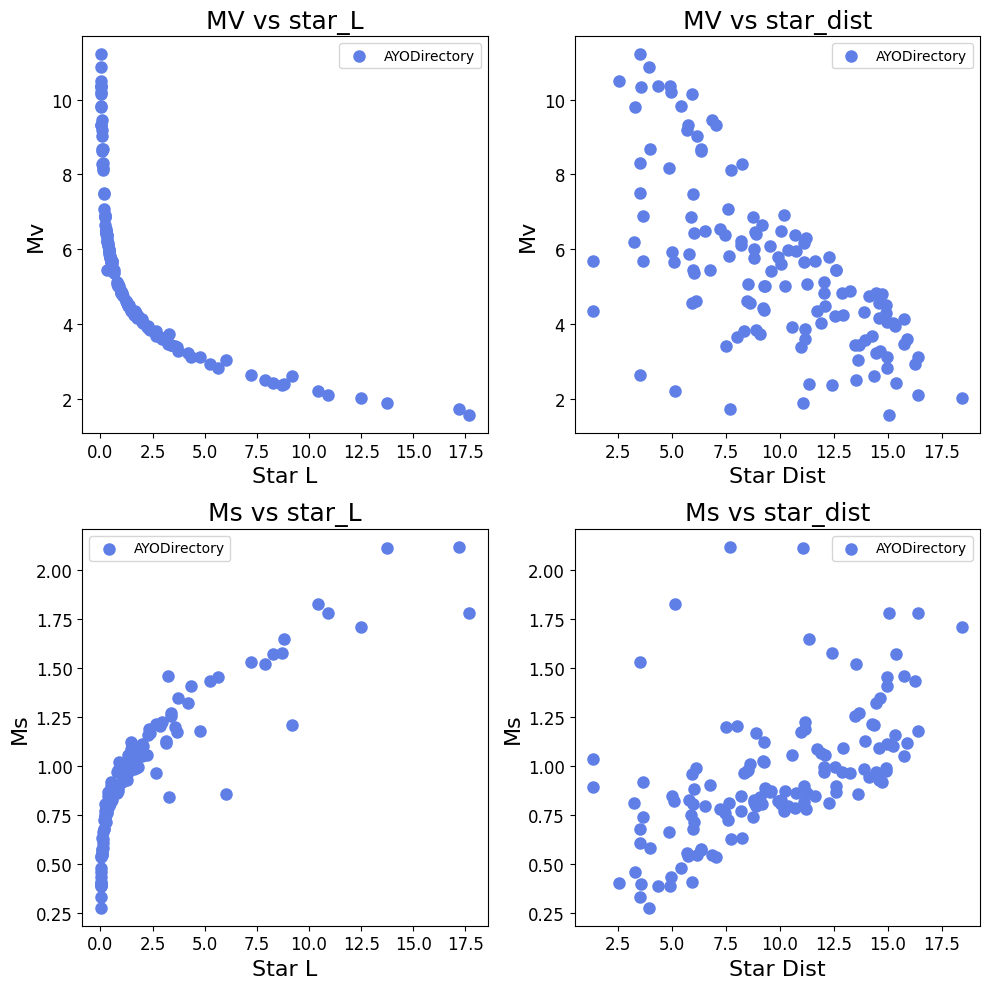

In [31]:
# Plot a grid of parameters against each other.
fig, axs = ypl.xy_grid(
    [ayo],
    ["star_L", "star_dist"],
    ["MV", "Ms"],
    plot_type="scatter",
    legend=True,
)
plt.show()

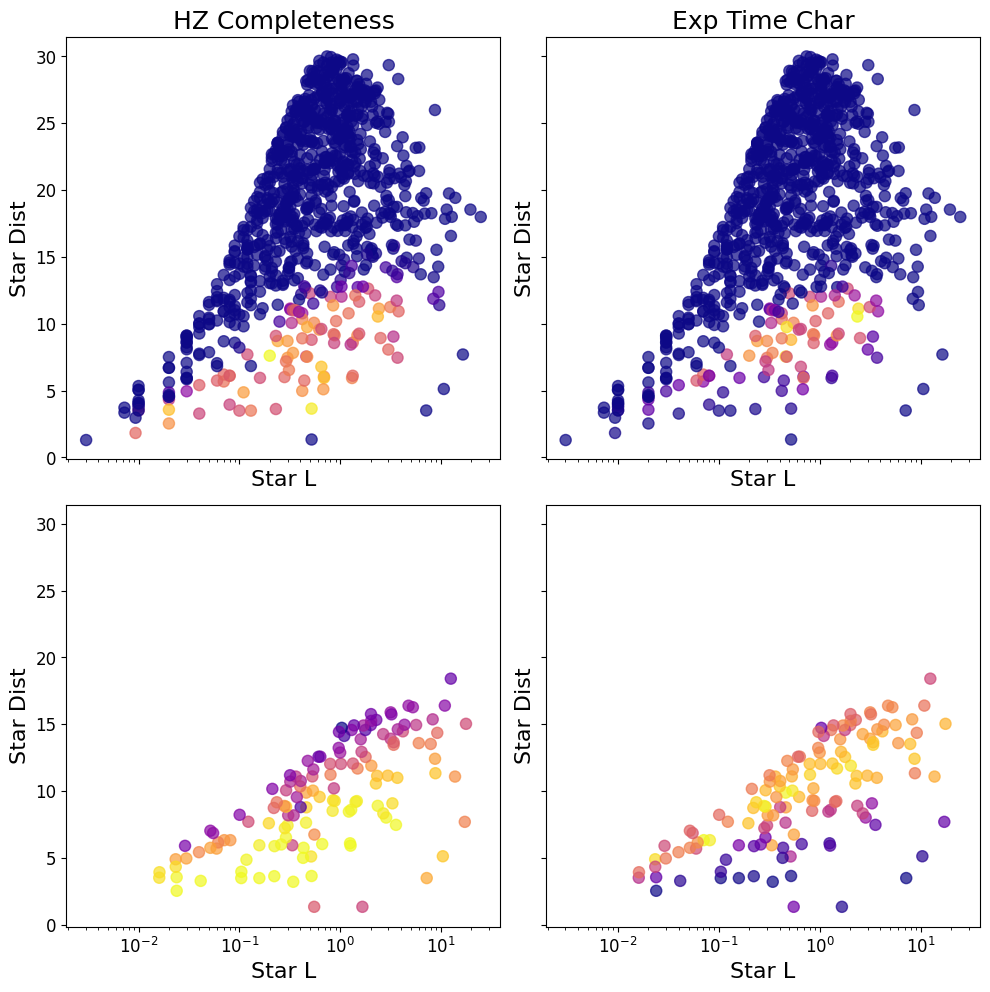

In [23]:
# Plot multiple panels with different specifications for each yield run.

spec1 = {
    "x": "star_L",
    "y": "star_dist",
    "plot_type": "scatter",
    "c": "star_comp_det",
    "alpha": 0.7,
}
spec2 = {
    "x": "star_L",
    "y": "star_dist",
    "plot_type": "scatter",
    "c": "exp_time_char",
    "alpha": 0.7,
}
specs = [spec1, spec2]

fig, axes = ypl.panel(
    [exosims, ayo],
    *specs,
    figsize=(10, 10),
    suptitle=None,
    layout=None,
    sharex=True,
    sharey=True,
    titles=["HZ Completeness", "Exp Time Char", "", ""],
)
axes[1, 0].set_xscale("log")
plt.show()

## Yield Input Package (YIP) Loading
yieldplotlib supports the loading and plotting of yield input packages using yippy as a back end. YIPs specify relevant coronagraph parameters for yield codes and so are often critical inputs to be able to vet and visualize.  

In [24]:
# Load the YIP
yip_folder = Path("sample_data/yip")
yip = YIPDirectory(yip_folder)

FileNotFoundError: [Errno 2] No such file or directory: 'sample_data/yip'

In [ ]:
plot_core_throughtput(
    [exosims], ["EXOSIMS"], yip=yip, ax_kwargs={"xlim": (0, 32), "ylim": (0, 0.4)}
)

In [ ]:
# Make GIF animation of the off-axis stellar PSF.
ani = make_offax_psf_movie(yip, "offax_psf_animation.gif")

# Code to easily view the animation in the notebook.
HTML(ani.to_jshtml())

## Checking Accessibility 

yieldplotlib has a built-in class to check the accessibility of plots. This includes ensuring that colorbars are monotonic, have adequate range, and that all font sizes are large enough to be easily readable. This class is 
currently very basic and so is not designed to catch all potential accessibility issues. Instead, it is meant to alert for commonly encountered problems and to make the user think about their choices with intentionality.   

<Figure size 640x480 with 0 Axes>

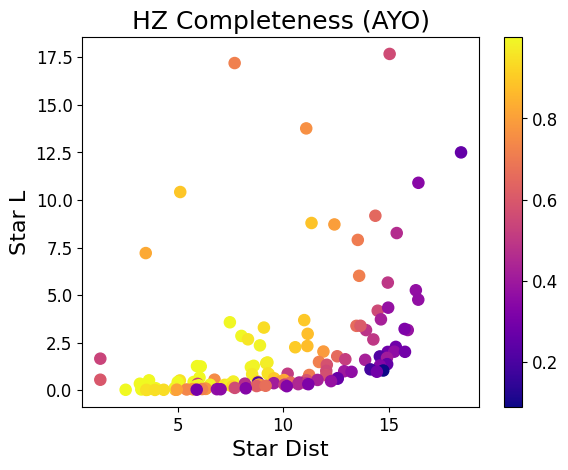

[yieldplotlib] WARNING [2025-03-25 16:28:52,007] Colors may not be monotonic
[yieldplotlib] WARNING [2025-03-25 16:28:52,008] 1 accessibility checks failed.


In [40]:
# Passing Example
# Note: colored scatter points will always fail the broad monotonic color check.
plt.set_cmap("plasma")
fig, ax = plt.subplots()
data = ax.ypl_scatter(ayo, x="star_dist", y="star_L", c="star_comp_det")
ax.set_title("HZ Completeness (AYO)")
plt.colorbar(data)
plt.show()

am = AccessibilityManager(ax)
am.run_checks()

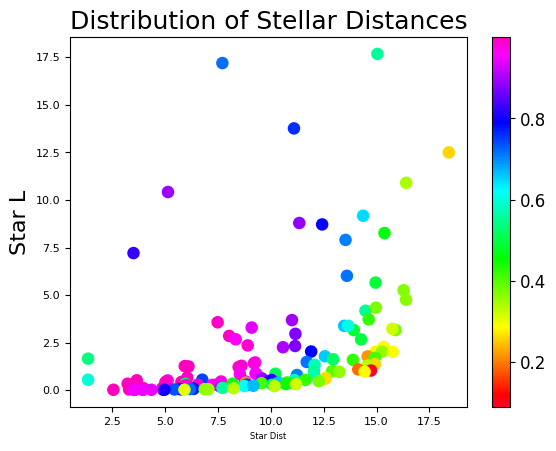

[yieldplotlib] WARNING [2025-03-25 16:29:04,390] Colormap for scatter points is not monotonic
[yieldplotlib] WARNING [2025-03-25 16:29:04,391] Colors may not be monotonic
[yieldplotlib] WARNING [2025-03-25 16:29:04,393] The following font sizes are likely too small and could present readability issues {'xaxis.label': 6.0, 'get_xticklabels': 8.0, 'get_yticklabels': 8.0}
[yieldplotlib] WARNING [2025-03-25 16:29:04,393] 3 accessibility checks failed.


In [42]:
# Failing Example
fig, ax = plt.subplots()

# Set a bad (non monotonic) colormap.
plt.set_cmap("gist_rainbow")

data = ax.ypl_scatter(ayo, x="star_dist", y="star_L", c="star_comp_det")
ax.set_title("HZ Completeness (AYO)")
plt.colorbar(data)

# Decrease Font Sizes
ax.set_xlabel("Star Dist", fontsize=6)
ax.tick_params(axis="both", which="major", labelsize=8)

ax.set_title("Distribution of Stellar Distances")
plt.show()

am = AccessibilityManager(ax)
am.run_checks()